# skeleton 시각화
## 720p로 간단하게 확인

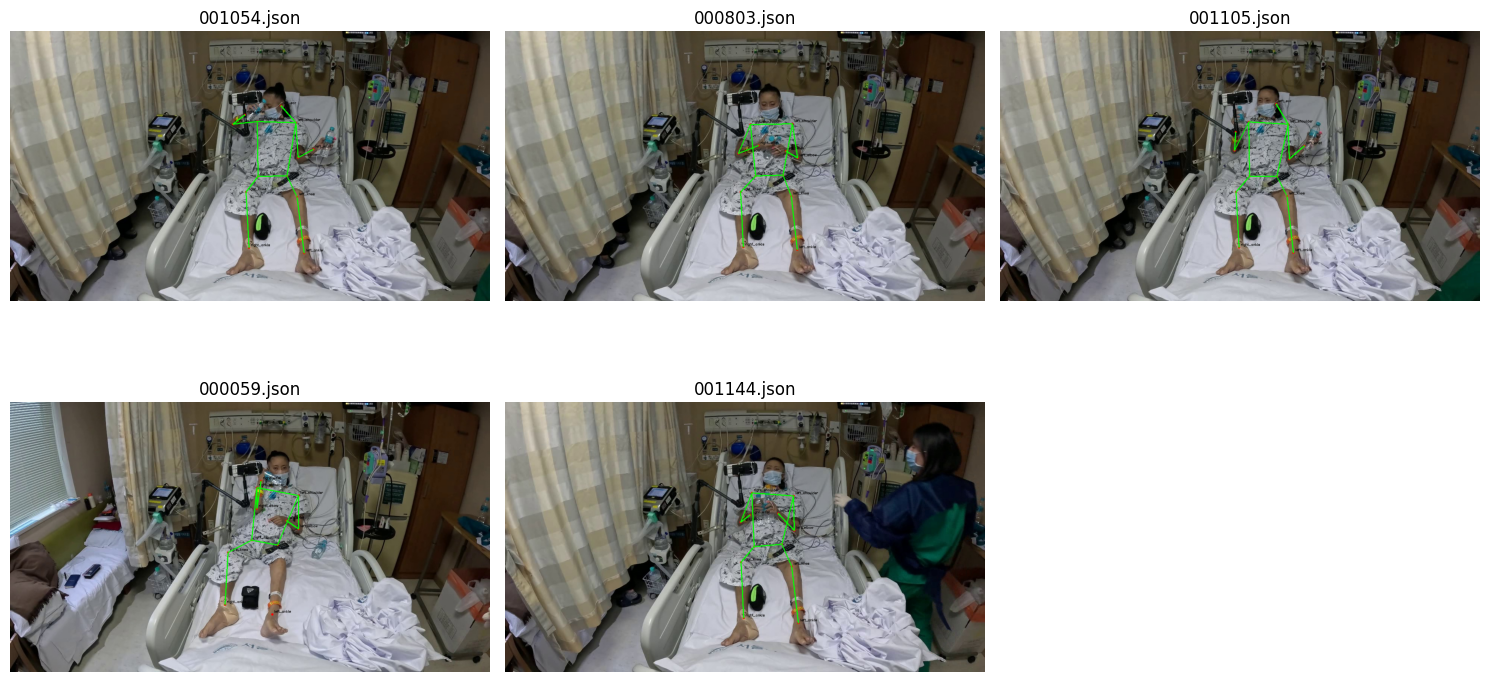

In [7]:
import os  # 경로
import json  # JSON 로드
import cv2  # 이미지 처리
import numpy as np  # 수치 계산
from pathlib import Path  # 경로 객체
import matplotlib.pyplot as plt  # 시각화
import random  # 랜덤 샘플링

# JSON 폴더 (상대경로)
json_dir = Path("../data/Patient_data/sapiens_output/M08_visit6_상하지_1.MP4_JSON/sapiens_0.3b")

# 프레임 이미지 폴더 (절대경로)
frame_dir = Path("/workspace/nas203/ds_RehabilitationMedicineData/data/김원 보산진 연구/resize/M08visit6상하지1resized_frames")

# 모든 json 파일 목록
json_files = sorted([f for f in json_dir.glob("*.json")])

# 랜덤으로 5개 선택
sample_files = random.sample(json_files, 5)

def visualize_skeleton_on_frame(json_path):
    # JSON 로드
    with open(json_path, "r") as f:
        data = json.load(f)

    keypoint_id2name = {int(k): v for k, v in data["meta_info"]["keypoint_id2name"].items()}
    skeleton_links = data["meta_info"]["skeleton_links"]

    instance = data["instance_info"][0]  # 첫 번째 instance
    keypoints = np.array(instance["keypoints"])
    scores = np.array(instance["keypoint_scores"])

    # 프레임 이름 (예: 000123.json → 000123.jpg)
    frame_name = json_path.stem + ".jpg"
    frame_path = frame_dir / frame_name

    # 이미지 로드
    img = cv2.imread(str(frame_path))
    if img is None:
        img = np.ones((720, 1280, 3), dtype=np.uint8) * 255  # 없으면 흰 배경

    # keypoint 점 찍기
    for i, (x, y) in enumerate(keypoints):
        if scores[i] > 0.05:
            cv2.circle(img, (int(x), int(y)), 3, (0, 0, 255), -1)
            cv2.putText(img, keypoint_id2name[i], (int(x)+5, int(y)-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,0), 1)

    # skeleton 연결선 그리기
    for (i, j) in skeleton_links:
        if scores[i] > 0.05 and scores[j] > 0.05:
            pt1, pt2 = tuple(map(int, keypoints[i])), tuple(map(int, keypoints[j]))
            cv2.line(img, pt1, pt2, (0, 255, 0), 2)

    # OpenCV BGR → matplotlib RGB 변환
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 랜덤 샘플 5개 시각화
plt.figure(figsize=(15, 8))
for idx, json_file in enumerate(sample_files):
    plt.subplot(2, 3, idx+1)
    img = visualize_skeleton_on_frame(json_file)
    plt.imshow(img)
    plt.title(json_file.name)
    plt.axis("off")
plt.tight_layout()
plt.show()


## 원본화질에 적용해보기
해보니까 시간만 오래걸림. 그냥 720p로 만들어도 될듯.  
일단은 몇개만 만들고 대기.

In [21]:
import cv2
import json
from pathlib import Path
from tqdm import tqdm  # 진행률 표시

# -----------------------------
# 설정
# -----------------------------
video_path = "/workspace/nas203/ds_RehabilitationMedicineData/data/김원 보산진 연구/M08_visit6_상하지_1.MP4"
json_dir   = "../data/Patient_data/sapiens_output/M08_visit6_상하지_1.MP4_JSON/sapiens_0.3b"
out_dir    = Path("../data/Patient_data/sapiens_output/M08_visit6_상하지_1.MP4_JSON/overlay_preview")
down_w, down_h = 1280, 720  # 추론(720p) 해상도 기준

# -----------------------------
# 출력 디렉토리 준비
# -----------------------------
out_dir.mkdir(parents=True, exist_ok=True)

# -----------------------------
# JSON 불러오기
# -----------------------------
json_files = sorted(Path(json_dir).glob("*.json"))
print(f"[DEBUG] JSON 파일 {len(json_files)}개 발견")

# 첫 번째 JSON에서 skeleton 정의 읽기
with open(json_files[0], "r") as f:
    meta = json.load(f)["meta_info"]
skeleton_links = meta["skeleton_links"]
skeleton_colors = meta["skeleton_link_colors"]["__ndarray__"]
kp_colors = meta["keypoint_colors"]["__ndarray__"]

# -----------------------------
# 원본 영상 정보
# -----------------------------
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError(f"[ERROR] 영상 열기 실패: {video_path}")

orig_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
orig_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"[DEBUG] 원본 해상도: {orig_w} x {orig_h}")

scale_x = orig_w / down_w
scale_y = orig_h / down_h
print(f"[DEBUG] 스케일 factor: ({scale_x:.2f}, {scale_y:.2f})")

# -----------------------------
# 전체 프레임 처리 (tqdm 진행률)
# -----------------------------
for jf in tqdm(json_files, desc="Overlay 생성 중"):
    frame_idx = int(jf.stem)  # 파일명 → 프레임 번호
    with open(jf, "r") as f:
        data = json.load(f)

    instance = data["instance_info"][0]  # 환자 1명 가정
    kps = instance["keypoints"]

    kps_scaled = [(int(x * scale_x), int(y * scale_y)) for x, y in kps]

    # 프레임 불러오기
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    if not ret:
        continue

    # Skeleton 선 그리기 (굵기 ↑)
    for link, color in zip(skeleton_links, skeleton_colors):
        i, j = link
        if i < len(kps_scaled) and j < len(kps_scaled):
            pt1, pt2 = kps_scaled[i], kps_scaled[j]
            cv2.line(frame, pt1, pt2, tuple(color), thickness=20)

    # Keypoints 점 그리기 (크기 ↑)
    for (x, y), color in zip(kps_scaled, kp_colors):
        cv2.circle(frame, (x, y), radius=15, color=tuple(color), thickness=-1)

    # 저장
    out_path = out_dir / f"frame_{frame_idx:06d}.png"
    cv2.imwrite(str(out_path), frame)

cap.release()


[DEBUG] JSON 파일 1592개 발견
[DEBUG] 원본 해상도: 3840 x 2160
[DEBUG] 스케일 factor: (3.00, 3.00)


Overlay 생성 중: 100% 1592/1592 [39:58<00:00,  1.51s/it]


In [22]:
import cv2
from pathlib import Path
from tqdm import tqdm

# -----------------------------
# 설정
# -----------------------------
img_dir = Path("../data/Patient_data/sapiens_output/M08_visit6_상하지_1.MP4_JSON/overlay_preview")  # PNG 저장 폴더
out_path = "../data/Patient_data/sapiens_output/M08_visit6_상하지_1.MP4_JSON/overlay_preview.mp4"   # 출력 MP4
fps = 30  # 원본 영상 fps 맞춰주세요 (예: 30)

# -----------------------------
# 이미지 파일 로드
# -----------------------------
img_files = sorted(img_dir.glob("*.png"))
if not img_files:
    raise RuntimeError(f"[ERROR] PNG 파일 없음: {img_dir}")
print(f"[DEBUG] 총 {len(img_files)}장 이미지 발견")

# 첫 번째 이미지로 해상도 결정
sample = cv2.imread(str(img_files[0]))
h, w, _ = sample.shape
print(f"[DEBUG] 출력 해상도: {w}x{h}")

# -----------------------------
# VideoWriter 설정
# -----------------------------
fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # mp4 코덱
writer = cv2.VideoWriter(out_path, fourcc, fps, (w, h))

# -----------------------------
# 이미지 → 비디오
# -----------------------------
for f in tqdm(img_files, desc="MP4 생성 중"):
    frame = cv2.imread(str(f))
    writer.write(frame)

writer.release()
print(f"[SAVE] {out_path}")


[DEBUG] 총 1592장 이미지 발견
[DEBUG] 출력 해상도: 3840x2160


MP4 생성 중: 100% 1592/1592 [06:05<00:00,  4.35it/s]

[SAVE] ../data/Patient_data/sapiens_output/M08_visit6_상하지_1.MP4_JSON/overlay_preview.mp4
